In [1]:
# inline plotting instead of popping out
%matplotlib inline

# python 3.7.3
from IPython.display import Image

# numpy  1.17.1
import numpy as np

# pandas  0.25.1
import pandas as pd

# matplotlib  3.1.1
import matplotlib.pyplot as plt

# scikit-learn  0.21.3
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge, RidgeClassifier

from pylab import *
import csv

In [2]:
X_train = pd.read_csv('./data/nba/X_train.csv')
y_train = pd.read_csv('./data/nba/y_train.csv')
X_test = pd.read_csv('./data/nba/X_test.csv')
df = X_train

In [3]:
print(X_train.columns)
print(y_train.columns)

Index(['PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST'],
      dtype='object')
Index(['FGM'], dtype='object')


In [4]:
def pd2np(df):
    return df.values

In [5]:
X_train = pd2np(X_train)
y_train = pd2np(y_train)
X_test = pd2np(X_test)
sc_x = StandardScaler()
X_train_std = sc_x.fit_transform(X_train)
X_test_std  = sc_x.transform(X_test)
X_origin_std = X_train_std
y_origin = y_train

In [6]:
print(X_train.shape)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_std, y_train, test_size=0.3, random_state=0)
print(X_train.shape, X_valid.shape, X_test.shape)

(52399, 8)
(36679, 8) (15720, 8) (13100, 8)


In [7]:
for a in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]:
    lr_rg = Lasso(alpha=a)
    lr_rg.fit(X_train, y_train)

    y_train_pred = lr_rg.predict(X_train)
    y_valid_pred = lr_rg.predict(X_valid)

    print('\n[Alpha = %.5f]' % a )
    print('MSE train: %.5f, valid: %.5f' % (
                    mean_squared_error(y_train, y_train_pred),
                    mean_squared_error(y_valid, y_valid_pred)))  


[Alpha = 0.00001]
MSE train: 0.23456, valid: 0.23345

[Alpha = 0.00010]
MSE train: 0.23456, valid: 0.23343

[Alpha = 0.00100]
MSE train: 0.23460, valid: 0.23332

[Alpha = 0.01000]
MSE train: 0.23516, valid: 0.23415

[Alpha = 0.10000]
MSE train: 0.24803, valid: 0.24821

[Alpha = 1.00000]
MSE train: 0.24803, valid: 0.24821

[Alpha = 10.00000]
MSE train: 0.24803, valid: 0.24821


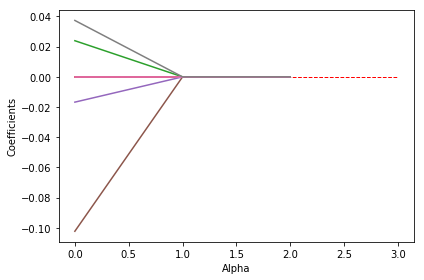

In [8]:
X_a, X_b, y_a, y_b = train_test_split(
    X_train, y_train, test_size=0.3, random_state=0)

max_alpha = 3
coef_ = np.zeros((max_alpha,8))

for a in range(3):
    lr_rg = Lasso(alpha = a+0.01)
    lr_rg.fit(X_a, y_a)

    y_a_pred = lr_rg.predict(X_a)
    y_b_pred = lr_rg.predict(X_b)
    coef_[a,:] = lr_rg.coef_.reshape(1,-1)
    
plt.hlines(y=0, xmin=0, xmax=max_alpha, color='red', linewidth = 1, linestyle = '--')

for i in range(8):
    plt.plot(range(max_alpha),coef_[:,i])
    
plt.ylabel('Coefficients')
plt.xlabel('Alpha')
plt.tight_layout()
plt.show()

## The top-3 features you find and how you find it
使用Lab05裡的方法用LASSO for Feature Selection
然後再調整alpha
在調整epsilon使剛好挑到只剩下三個feature

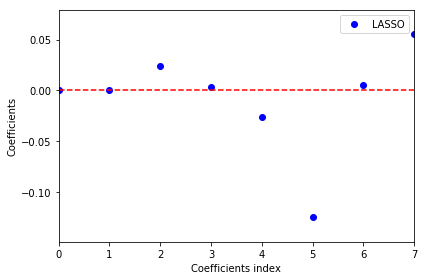

Selected attributes: Index(['TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST'], dtype='object')


In [9]:
var_num = X_train.shape[1]

lr_lasso = Lasso(alpha = 0.001)
lr_lasso.fit(X_train, y_train)

plt.scatter(range(var_num),lr_lasso.coef_, label = 'LASSO', color = 'blue')
plt.hlines(y=0, xmin=0, xmax=var_num-1, color='red', linestyle ='--')
plt.xlim(0, var_num - 1)
plt.legend(loc = 'upper right')
plt.xlabel('Coefficients index')
plt.ylabel('Coefficients')
plt.tight_layout()
plt.show()

epsilon = 0.025

idxs = np.where(abs(lr_lasso.coef_) > epsilon)
print('Selected attributes: {}'.format(df.columns[idxs]))

In [10]:
dict = {"TOUCH_TIME": X_origin_std[:,idxs[0][0]],  
        'SHOT_DIST' : X_origin_std[:,idxs[0][1]],
        'CLOSE_DEF_DIST' : X_origin_std[:,idxs[0][2]]
       }

select_df = pd.DataFrame(dict)
X_train = pd2np(select_df)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_origin, test_size=0.3, random_state=0)

dict = {"TOUCH_TIME": X_test_std[:,idxs[0][0]],  
        'SHOT_DIST' : X_test_std[:,idxs[0][1]],
        'CLOSE_DEF_DIST' : X_test_std[:,idxs[0][2]]
        }

select_df2 = pd.DataFrame(dict)
X_test = pd2np(select_df2)

## Plot the error curve of your best model and tell if it is over-fit or not
用Decisiton Tree來當我最好的model，
很明顯tree的depth越深，training error越高，valid error越低，
代表存在著overfit的情形。

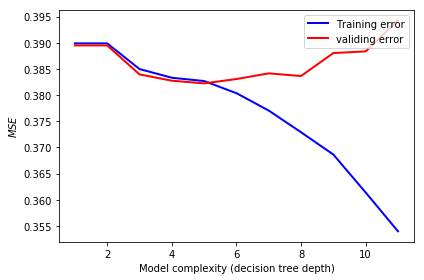

In [11]:
mse_train = []
mse_test = []

max_depth = 12

for d in range(1, max_depth):
    tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=d, 
                              random_state=0)
    tree.fit(X_train, y_train)
    y_train_pred = tree.predict(X_train)
    y_valid_pred = tree.predict(X_valid) 
    
    mse_train.append(mean_squared_error(y_train, y_train_pred))
    mse_test.append(mean_squared_error(y_valid, y_valid_pred))
    

plt.plot(range(1, max_depth), mse_train, label = 'Training error', color = 'blue', linewidth = 2)
plt.plot(range(1, max_depth), mse_test, label = 'validing error', color = 'red', linewidth = 2)
plt.legend(loc='upper right')
plt.xlabel('Model complexity (decision tree depth)')
plt.ylabel('$MSE$')
plt.tight_layout()
plt.show()

/Users/shenxiu5651/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.51357e-18): result may not be accurate.
  overwrite_a=True).T
/Users/shenxiu5651/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.80251e-20): result may not be accurate.
  overwrite_a=True).T
/Users/shenxiu5651/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.15152e-23): result may not be accurate.
  overwrite_a=True).T
/Users/shenxiu5651/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.57539e-25): result may not be accurate.
  overwrite_a=True).T
/Users/shenxiu5651/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.8692e-28): result may not be accurate.
  overwrite_a=True

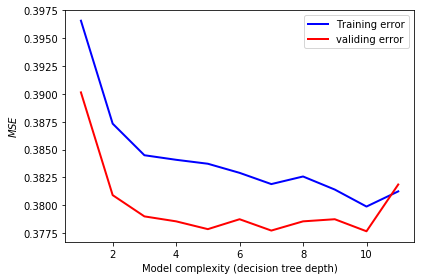

In [12]:
mse_train = []
mse_test = []

max_depth = 12

for d in range(1, max_depth):
    poly = PolynomialFeatures(degree=d)
    X_train_poly = poly.fit_transform(X_train)
    X_valid_poly = poly.transform(X_valid)
    X_test_poly  = poly.transform(X_test)
    
    lr_rg = RidgeClassifier(alpha=10)
    lr_rg.fit(X_train_poly,  y_train[:,0])

    y_train_pred = lr_rg.predict(X_train_poly)
    y_valid_pred = lr_rg.predict(X_valid_poly)
    y_test_pred  = lr_rg.predict(X_test_poly)
    
    mse_train.append(mean_squared_error(y_train, y_train_pred))
    mse_test.append(mean_squared_error(y_valid, y_valid_pred))

plt.plot(range(1, max_depth), mse_train, label = 'Training error', color = 'blue', linewidth = 2)
plt.plot(range(1, max_depth), mse_test, label = 'validing error', color = 'red', linewidth = 2)
plt.legend(loc='upper right')
plt.xlabel('Model complexity (decision tree depth)')
plt.ylabel('$MSE$')
plt.tight_layout()
plt.show()

## All models you have tried and the result
我有用decision tree, random forest, ridge classifer
結果如下，
decision tree:
    MSE train: 0.38270, valid: 0.38225
    Accuracy train: 0.62, valid: 0.62
random forest:
    MSE train: 0.02492, valid: 0.43092
    Accuracy train: 0.98, valid: 0.57
ridge classifier:
    Alpha = 10
    MSE train: 0.38191, valid: 0.37774
    Accuracy train: 0.62, valid: 0.62

而ridge classifier結果比較好


## How you evaluate your model
evaluate基本上是看MSE以及最後的accuracy

In [13]:
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=200, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train[:,0])
y_train_pred = forest.predict(X_train)
y_valid_pred = forest.predict(X_valid)
y_test_pred  = forest.predict(X_test)

print('MSE train: %.5f, valid: %.5f' % (
                    mean_squared_error(y_train, y_train_pred),
                    mean_squared_error(y_valid, y_valid_pred))) 
print('Accuracy train: %.2f, valid: %.2f' % (
                    (y_train == y_train_pred[:,np.newaxis]).sum() / y_train.shape[0],
                    (y_valid == y_valid_pred[:,np.newaxis]).sum() / y_valid.shape[0]))

MSE train: 0.02492, valid: 0.43092
Accuracy train: 0.98, valid: 0.57


In [14]:
tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=5, 
                              random_state=0)
tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_valid_pred = tree.predict(X_valid)
y_test_pred  = tree.predict(X_test)

print('MSE train: %.5f, valid: %.5f' % (
                    mean_squared_error(y_train, y_train_pred[:,np.newaxis]),
                    mean_squared_error(y_valid, y_valid_pred[:,np.newaxis]))) 
print('Accuracy train: %.2f, valid: %.2f' % (
                    (y_train == y_train_pred[:,np.newaxis]).sum() / y_train.shape[0],
                    (y_valid == y_valid_pred[:,np.newaxis]).sum() / y_valid.shape[0]))

MSE train: 0.38270, valid: 0.38225
Accuracy train: 0.62, valid: 0.62


In [15]:
poly = PolynomialFeatures(degree=8)
X_train_poly = poly.fit_transform(X_train)
X_valid_poly = poly.transform(X_valid)
X_test_poly  = poly.transform(X_test)


lr_rg = RidgeClassifier(alpha=10)
lr_rg.fit(X_train_poly, y_train)

y_train_pred = lr_rg.predict(X_train_poly)
y_valid_pred = lr_rg.predict(X_valid_poly)
y_test_pred  = lr_rg.predict(X_test_poly)


print('\n[Alpha = %d]' % 10 )
print('MSE train: %.5f, valid: %.5f' % (
                mean_squared_error(y_train, y_train_pred[:,np.newaxis]),
                mean_squared_error(y_valid, y_valid_pred[:,np.newaxis]))) 
print('Accuracy train: %.2f, valid: %.2f' % (
                (y_train == y_train_pred[:,np.newaxis]).sum() / y_train.shape[0],
                (y_valid == y_valid_pred[:,np.newaxis]).sum() / y_valid.shape[0]))
    


[Alpha = 10]
MSE train: 0.38259, valid: 0.37856
Accuracy train: 0.62, valid: 0.62


/Users/shenxiu5651/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:839: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shenxiu5651/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.80251e-20): result may not be accurate.
  overwrite_a=True).T


In [16]:
print(y_test_pred)
print(y_test_pred.shape)

pd.DataFrame(y_test_pred).to_csv('./data/nba/y_pred.csv',header=["FGM"], index=None)

[1 0 0 ... 0 0 0]
(13100,)


## Brief report
基本上就是先把data都std後，
再照著Lab05裡面的Lasso流程，
來進行feature selection，
之後用select後的feature套入decision tree, random forest model
來比較結果